# Classification of Symbols


- Torch is main pytorch module. 
- The `nn` module contains things like layer definitions, activations, loss functions etc.
- The helper module `functional` provides almost same functionality as the `nn` module. Don't need to initialize object for activation function.
- The `optim` module contains the hyper-optimizers
- `torchvision` is the computer vision module of pytorch.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
import torch.optim as optim
from torchvision import datasets, transforms

## Define the model

- In Pytorch, to define the neural network model, you have to define class e.g. `Net`. It has to inherit from the `nn` module.
- Another way is sequential way => define what layers your NN has.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        """
        - We have 3 layers (500, 1000, 10). The last one is importance since we have 10 classes and we need 10 output neurons.
        - The args contain  no. of input and output nodes. E.g. input node of first layer has 784 nodes. 
        - Why 784? Coz the MNIST dataset has 28x28 px images = 784
        - Last layer is more specific, because we have 10 classes that we're trying to recognise.
        - fc = fully connected
        """
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 1000)
        self.fc3 = nn.Linear(1000, 10)


    """
    - In Pytorch, if you define forward pass through network, then it uses `autograd` library to automatically calculate the backward pass.
    - it takes `x` vector or tensor as input.
    - the vector is of size 784 at the beginning.
    """
    def forward(self, x):
        x = x.view(-1, 784)   # x.view(<batch-size>, 784). When batch-size = -1 => you don't care about the batch size.
        
        x = F.relu(self.fc1(x))  # fc layer 1 is connected to input vector. And ReLU activation function is applied to it.
        x = F.relu(self.fc2(x))  # do the same but for layer two.
        x = self.fc3(x)          # don't apply AF here. Only Linear function

        """
        - logarithmic softmax function applied here. Output of network isn't of size 10 where every value = probability
        - softmax value which has highest probability.
        """
        return F.log_softmax(x, dim=1)  

## Loading the data

We use `DataLoader` and `DataSet` `torch` `util` classes

In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=True, # train parameter here decides whether the dataset is training or testing as per the boolean flag
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    batch_size=128, shuffle=True  # shuffle set as True to make results generic
                )

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    batch_size=128, shuffle=True
                )


## Training and testing loops

- Boiler plate code for training and testing.
- Most ML Frameworks don't expose this part of code.
- However since PyTorch framework is used for experimental research, you have full control over how a model is trained/tested.

In [12]:
"""
the train() accepts the 
    neural network `model`, 
    the `device` on which to run it, 
    the `train_loader` training dataset, epoch and optimizer
"""
def train(model, device, train_loader, optimizer, epoch):
    model.train()   # biases in the model can be changed.
    for batch_idx, (data, target) in enumerate(train_loader):  # running with enum, coz wanna know batch index current loss
        data, target = data.to(device), target.to(device)   # move data and target to the device e.g. graphics card. edge programming
        optimizer.zero_grad()  # set up fresh calculations
        output = model(data)   # running data through fwd pass and get output at current step
        loss = F.nll_loss(output, target)  # loss at curr. step using negative log likelihood loss coz it works well for softmax output
        loss.backward()    # PyTorch feature. By doing back-propagation through network, can be done automatically.
        optimizer.step()   # changes the parameters in the network
        if batch_idx%100 == 0:
            # print every 100 batches
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(data), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()
            ))

In [13]:
def test(model, device, test_loader):
    model.eval()   # model during eval mode will NOT change parameters
    test_loss = 0
    correct = 0    # we count how many test sets got correct
    with torch.no_grad():  # speeds up the process. We tell don't remeber gradients so make faster processing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)   # running the data through the model

            # since we're testing in batch, we're interested in only sum of all losses in the batch
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)   # get index of maxiumum o/p probability from the o/p vector

            # count how many samples we got correct/incorrect. Compare the correct labels in batch and sum them up.
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)
    ))

## Running the Model

In [17]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(42) # for reproducible results, set random weight

device = torch.device("cuda" if use_cuda else "mps") # PyTorch added support for M1 GPU on May 2022

model = Net().to(device)  # Move the model to the device.
"""
- We've to tell it what it is optimizing. 
- A helper method parameters() can be called in any neural network model in PyTorch
- It calls all the params based on the fwd function.
"""
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5) 

# test before training

for epoch in range(1, 3+1):  # train for 3 epochs, and test after running each epoch.
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist.pt")  # save the model to `mnist.pt`


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299149
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.434354
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.288404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.237406
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.229125

Test Set: Average Loss: 0.1687, Accuracy: 9504/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.117743
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.153799
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.088753
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.048535
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.125453

Test Set: Average Loss: 0.1097, Accuracy: 9647/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168136
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.094888
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.057408
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.085881
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.055911

Test Set: Average Loss: 0.0859, Accuracy: 9733/10000 (97%)



## Testing the Model

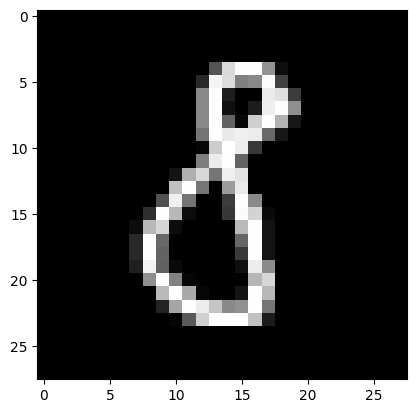

In [18]:
import matplotlib.pyplot as plt

test_image = test_loader.dataset.data[1200]
plt.imshow(test_image, cmap='gray')

In [25]:
# RUN THE IMAGE THROUGH MODEL
#out = model(test_image.float().cuda()))  <--- for CUDA support
out = model(test_image.float().to(torch.device('mps')))  # <--- for Mac M1 GPUs
out

tensor([[-173.2375,  -63.7640, -233.0796,  -67.2465, -341.3364, -221.4524,
         -284.8539, -358.5439,    0.0000, -290.2952]], device='mps:0',
       grad_fn=<LogSoftmaxBackward0>)

in above output, all values in the 10 unit vector output are negative or zero except for the index value.

In [24]:
out.argmax(dim=1)

tensor([8], device='mps:0')